STEP 1: Data Loading and Processing

In [3]:
# Task 1.1 : Load OpenLORIS-Object Data
import os
import zipfile
from PIL import Image
import numpy as np
import io

def load_openloris_data(data_path, max_images_per_object=3):
    """
    Load the OpenLORIS-Object dataset from a zip file, with an option to limit the number of images per object.

    Parameters:
    data_path (str): Path to the directory containing the 'test.zip' file of the OpenLORIS-Object dataset.
    max_images_per_object (int, optional): Maximum number of images to load per object. If None, load all images.

    Returns:
    dict: A nested dictionary with the following structure:
        {
            'test': {
                'rgb': {
                    'factor': {
                        'segment': {
                            'object': np.array of shape (n_frames, height, width, 3)
                        }
                    }
                }
            }
        }
        Where:
        - 'factor' is one of: 'illumination', 'occlusion', 'pixel', 'clutter'
        - 'segment' is like 'segment1', 'segment2', etc.
        - 'object' is like 'bottle_01', 'cup_02', etc.
        - The numpy array contains the RGB image data for each frame of the object

    Raises:
    FileNotFoundError: If the 'test.zip' file is not found at the specified path.

    Note:
    - This function assumes a specific structure in the zip file:
      test/factor/segment/object/frame.jpg
    - Frames with inconsistent shapes within an object should be kept as lists instead of numpy arrays.
    - The function should print progress and warning messages during the loading process.
    """
    
    # Check if the zip file exists
    zip_file_path = os.path.join(data_path, 'test.zip')
    if not os.path.exists(zip_file_path):
        raise FileNotFoundError(f"Zip file 'test.zip' not found in the specified path: {data_path}")
    
    dataset = {'test': {'rgb': {}}}
    
    # Open the zip file and start processing
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        for file_name in zip_ref.namelist():
            # Skip directories
            if file_name.endswith('/'):
                continue
            
            # Parse the file path components
            path_parts = file_name.split('/')
            if len(path_parts) != 5:
                # Skip files that don't match the expected structure
                continue
            
            # Extract path components
            _, factor, segment, obj, frame_file = path_parts
            
            # Initialize the nested dictionary structure
            if factor not in dataset['test']['rgb']:
                dataset['test']['rgb'][factor] = {}
            if segment not in dataset['test']['rgb'][factor]:
                dataset['test']['rgb'][factor][segment] = {}
            if obj not in dataset['test']['rgb'][factor][segment]:
                dataset['test']['rgb'][factor][segment][obj] = []
            
            # Limit the number of images loaded per object
            if max_images_per_object is not None and len(dataset['test']['rgb'][factor][segment][obj]) >= max_images_per_object:
                continue
            
            # Read and load the image data
            with zip_ref.open(file_name) as file:
                try:
                    image = Image.open(file)
                    image_data = np.array(image)
                    
                    # Verify if the image data has 3 channels (RGB)
                    if image_data.ndim == 3 and image_data.shape[2] == 3:
                        dataset['test']['rgb'][factor][segment][obj].append(image_data)
                    else:
                        print(f"Warning: Skipping non-RGB image in file: {file_name}")
                except Exception as e:
                    print(f"Error loading image {file_name}: {e}")
    
    # Convert lists to numpy arrays where possible, keeping lists if shapes are inconsistent
    for factor in dataset['test']['rgb']:
        for segment in dataset['test']['rgb'][factor]:
            for obj in dataset['test']['rgb'][factor][segment]:
                shapes = {img.shape for img in dataset['test']['rgb'][factor][segment][obj]}
                if len(shapes) == 1:  # All shapes are consistent
                    dataset['test']['rgb'][factor][segment][obj] = np.array(dataset['test']['rgb'][factor][segment][obj])
                else:
                    print(f"Warning: Inconsistent image shapes for {obj} in {segment}/{factor}. Keeping as a list.")
    
    print("Data loading complete.")
    return dataset



In [4]:
# Example usage
if __name__ == "__main__":
    data_path = "."  # Path to the directory containing test.zip
    max_images = 3  # Limit to 5 images per object (the more image you load, the higher memory for processing is requried)
    dataset = load_openloris_data(data_path, max_images_per_object=max_images)

    # Print some information about the loaded data
    print("\nDataset structure:")
    for factor in dataset['test']['rgb']:
        print(f"\nFactor: {factor}")
        for segment in dataset['test']['rgb'][factor]:
            print(f"  Segment: {segment}")
            for object_name in dataset['test']['rgb'][factor][segment]:
                frames = dataset['test']['rgb'][factor][segment][object_name]
                if isinstance(frames, np.ndarray):
                    print(f"    Object: {object_name}, Number of frames: {len(frames)}, Frame shape: {frames[0].shape}")
                elif isinstance(frames, list):
                    print(f"    Object: {object_name}, Number of frames: {len(frames)}, Frame shapes vary")
                else:
                    print(f"    Object: {object_name}, Unexpected data type: {type(frames)}")

    # Verify that no object has more than max_images frames
    for factor in dataset['test']['rgb']:
        for segment in dataset['test']['rgb'][factor]:
            for object_name in dataset['test']['rgb'][factor][segment]:
                frames = dataset['test']['rgb'][factor][segment][object_name]
                assert len(frames) <= max_images, f"{object_name} in {factor}, {segment} has more than {max_images} frames"

    print(f"\nAll objects have {max_images} or fewer frames, as expected.")

Error loading image __MACOSX/test/illumination/segment4/._plug_04: cannot identify image file <zipfile.ZipExtFile name='__MACOSX/test/illumination/segment4/._plug_04' mode='r' compress_type=deflate>
Error loading image __MACOSX/test/illumination/segment4/._plug_03: cannot identify image file <zipfile.ZipExtFile name='__MACOSX/test/illumination/segment4/._plug_03' mode='r' compress_type=deflate>
Error loading image __MACOSX/test/illumination/segment4/._bowl_04: cannot identify image file <zipfile.ZipExtFile name='__MACOSX/test/illumination/segment4/._bowl_04' mode='r' compress_type=deflate>
Error loading image __MACOSX/test/illumination/segment4/._bowl_03: cannot identify image file <zipfile.ZipExtFile name='__MACOSX/test/illumination/segment4/._bowl_03' mode='r' compress_type=deflate>
Error loading image __MACOSX/test/illumination/segment4/._plug_02: cannot identify image file <zipfile.ZipExtFile name='__MACOSX/test/illumination/segment4/._plug_02' mode='r' compress_type=deflate>
Error

In [5]:
# Task 1.2: Preprocess data for DMD

import numpy as np

def preprocess_for_dmd(dataset, factor, segment, object_name):
    """
    Preprocess data for a specific object under a given factor and segment for DMD analysis.

    Parameters:
    dataset (dict): The dataset loaded by load_openloris_data
    factor (str): The factor to analyze (e.g., 'illumination', 'occlusion', 'pixel', 'clutter')
    segment (str): The segment to analyze (e.g., 'segment1', 'segment2', etc.)
    object_name (str): The object to analyze (e.g., 'bottle_01', 'cup_02', etc.)

    Returns:
    np.array: Preprocessed data suitable for DMD, shape (n_pixels * 3, n_frames)
    where n_pixels is the number of pixels in each frame (height * width),
    3 represents the RGB channels, and n_frames is the number of frames.

    Note:
    - This function should flatten each frame and stack them as columns.
    - The returned array should be of type float64 and normalized to the range [0, 1].
    """
    
    # Access the frames for the specified factor, segment, and object
    try:
        frames = dataset['test']['rgb'][factor][segment][object_name]
    except KeyError:
        raise ValueError(f"The specified factor, segment, or object '{object_name}' under '{factor}/{segment}' is not found in the dataset.")
    
    # Check if frames are loaded correctly
    if len(frames) == 0:
        raise ValueError(f"No frames available for object '{object_name}' in segment '{segment}' and factor '{factor}'.")

    # Get the shape of each frame (height, width, channels)
    height, width, channels = frames[0].shape
    n_pixels = height * width * channels
    n_frames = len(frames)
    
    # Initialize an array to store the preprocessed data
    dmd_data = np.zeros((n_pixels, n_frames), dtype=np.float64)
    
    # Flatten and normalize each frame, then store as a column in dmd_data
    for i, frame in enumerate(frames):
        # Flatten and normalize the frame
        dmd_data[:, i] = frame.flatten() / 255.0
    
    return dmd_data


Error loading image __MACOSX/test/illumination/segment4/._plug_04: cannot identify image file <zipfile.ZipExtFile name='__MACOSX/test/illumination/segment4/._plug_04' mode='r' compress_type=deflate>
Error loading image __MACOSX/test/illumination/segment4/._plug_03: cannot identify image file <zipfile.ZipExtFile name='__MACOSX/test/illumination/segment4/._plug_03' mode='r' compress_type=deflate>
Error loading image __MACOSX/test/illumination/segment4/._bowl_04: cannot identify image file <zipfile.ZipExtFile name='__MACOSX/test/illumination/segment4/._bowl_04' mode='r' compress_type=deflate>
Error loading image __MACOSX/test/illumination/segment4/._bowl_03: cannot identify image file <zipfile.ZipExtFile name='__MACOSX/test/illumination/segment4/._bowl_03' mode='r' compress_type=deflate>
Error loading image __MACOSX/test/illumination/segment4/._plug_02: cannot identify image file <zipfile.ZipExtFile name='__MACOSX/test/illumination/segment4/._plug_02' mode='r' compress_type=deflate>
Error

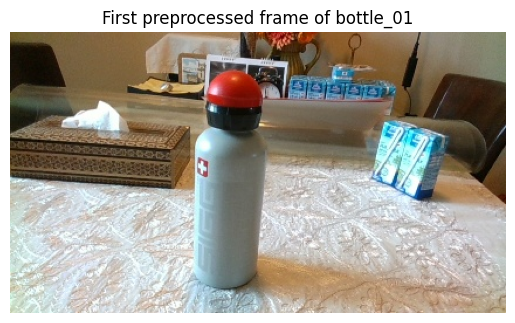

In [6]:
# Example usage
if __name__ == "__main__":
    # Assuming load_openloris_data is already implemented
    data_path = "."  # Path to the directory containing test.zip
    max_images = 2 # Limit to 5 images per object (the more image you load, the higher memory for processing is requried)
    dataset = load_openloris_data(data_path, max_images_per_object=max_images)

    # Choose a factor, segment, and object to preprocess
    factor = 'illumination'
    segment = 'segment1'
    object_name = 'bottle_01'

    # Preprocess the data
    preprocessed_data = preprocess_for_dmd(dataset, factor, segment, object_name)

    # Print information about the preprocessed data
    print(f"Preprocessed data shape: {preprocessed_data.shape}")
    print(f"Preprocessed data type: {preprocessed_data.dtype}")
    print(f"Preprocessed data range: [{preprocessed_data.min()}, {preprocessed_data.max()}]")

    # Additional checks
    original_frames = dataset['test']['rgb'][factor][segment][object_name]
    assert preprocessed_data.shape[1] == len(original_frames), "Number of frames doesn't match"
    assert preprocessed_data.shape[0] == np.prod(original_frames[0].shape), "Number of features doesn't match"
    assert preprocessed_data.dtype == np.float64, "Data type should be float64"
    assert 0 <= preprocessed_data.min() and preprocessed_data.max() <= 1, "Data should be normalized to [0, 1]"

    print("All checks passed! Your implementation looks correct.")

    # Visualize the first preprocessed frame
    import matplotlib.pyplot as plt
    
    first_frame = preprocessed_data[:, 0].reshape(original_frames[0].shape)
    plt.imshow(first_frame)
    plt.title(f"First preprocessed frame of {object_name}")
    plt.axis('off')
    plt.show()